In [ ]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
# 0.1 load data from file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving static_defenses_yards.csv to static_defenses_yards.csv
User uploaded file "static_defenses_yards.csv" with length 4999907 bytes


In [ ]:
static_defenses = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),index_col="id")
static_defenses.head()

,Unnamed: 0,defensivelinezonePlayers,deepzonePlayers,hookzonePlayers,curlzonePlayers,flatzonePlayers,defenseArea,defenseAreaCoverDefenders,width,height,numberQBs,numberWRs,numberTEs,numberRBs,numberFBs,numberOffensivePlayersAnotherPosition,numberSafeties,numberLBs,numberCBs,strongSide,numberPlayersDefenseStrongSide,numberPlayersDefenseWeakSide,numberPlayersOffenseStrongSide,numberPlayersOffenseWeakSide,differenceOffenseVsDefenseWidth,differenceOffenseVsDefenseStrongSide,differenceOffenseVsDefenseWeakSide,HeightByWeightDeep,HeightByWeightHook,HeightByWeightCurl,HeightByWeightFlat,WeightByArea,density,densityNoLine,densityInsidePoints,densityInsidePointsNoLine,playResult
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600:75:1,0,0,1,3,2,1,194.31095,194.31095,22.96,15.25,1,2,1,1,1,0,3,2,2,left,3,4,3,2,-0.63,0,-2,0.020227,0.018643,0.020066,0.021034,3.376032,0.036025,0.036025,6.974268,6.974268,10
2018090600:146:1,1,0,1,3,2,1,204.17725,204.17725,29.22,12.57,1,3,1,1,0,0,2,2,3,right,3,4,2,3,-1.15,-1,-1,0.020227,0.019228,0.020356,0.020455,3.178611,0.034284,0.034284,6.975511,6.975511,0
2018090600:168:1,2,0,1,2,2,2,277.65495,277.65495,33.67,15.21,1,2,1,2,0,0,2,2,3,left,5,2,4,1,0.71,-1,-1,0.020227,0.017683,0.020997,0.020745,2.337434,0.025211,0.025211,6.985594,6.985594,0
2018090600:190:1,3,1,0,2,3,1,189.16960,165.05520,26.42,12.91,1,3,1,1,0,0,3,1,3,right,2,5,2,3,-3.11,0,-2,0.000000,0.020120,0.021193,0.020455,3.192871,0.037004,0.036351,6.973569,6.969707,33
2018090600:320:1,5,1,0,3,3,1,187.12510,153.20020,27.80,13.29,1,3,1,1,0,0,2,3,3,left,3,5,3,2,-4.82,0,-3,0.000000,0.018995,0.019537,0.021279,4.281979,0.042752,0.045692,7.978624,7.980418,4


#Eliminar outliers

In [ ]:
#load dataset
pickle_file = open('outliers_minpts10_rs_3.pickle','rb')
outliers = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
for play in list(outliers):
    static_defenses.drop(play,inplace=True)

In [ ]:
#static_defenses = static_defenses[["numberWRs","width","HeightByWeightHook","densityInsidePointsNoLine","density","defenseAreaCoverDefenders","height","playResult"]]
static_defenses = static_defenses[["numberWRs","width","HeightByWeightHook","densityInsidePointsNoLine","density","defenseAreaCoverDefenders","playResult"]]
static_defenses.reset_index(drop=True)
static_defenses.head()

,numberWRs,width,HeightByWeightHook,densityInsidePointsNoLine,density,defenseAreaCoverDefenders,playResult
id,,,,,,,
2018090600:75:1,2,22.96,0.018643,6.974268,0.036025,194.31095,10
2018090600:146:1,3,29.22,0.019228,6.975511,0.034284,204.17725,0
2018090600:168:1,2,33.67,0.017683,6.985594,0.025211,277.65495,0
2018090600:190:1,3,26.42,0.020120,6.969707,0.037004,165.05520,33
2018090600:320:1,3,27.80,0.018995,7.980418,0.042752,153.20020,4


#Cambiar valor playResult

##5 etiquetas

Vamos a seguir el siguiente criterio:


*   Yardas negativas (-infinito,0)
*   Poco yardaje [0,3)
*   Yardaje medio [3,7)
*   Mucho yardaje [7,16)
*   Big play      [16, +infinito)



In [ ]:
def assignTag(number): 
  tag = ""
  if number < 0:
    tag = 0 #"negativeYards"
  elif number < 3:
    tag = 1 #"fewYards"
  elif number < 7:
    tag = 2 #"mediumYards"
  elif number < 16:
    tag = 3 #"muchYards"
  else:
    tag = 4 #"bigPlay"
  
  return tag

In [ ]:
static_defenses["playResult"].unique()

array([3, 1, 4, 2, 0])

In [ ]:
static_defenses["playResult"] = static_defenses["playResult"].apply(assignTag)

In [ ]:
static_defenses.to_csv("static_defenses_categorical_5.csv")

##Tres etiquetas, negativas, normales y big plays

In [ ]:
def assignTag(number): 
  tag = ""
  if number < 0:
    tag = 0 #"negativeYards"
  elif number < 16:
    tag = 1 #yards
  else:
    tag = 2 #"bigPlay"
  
  return tag

In [ ]:
static_defenses.to_csv("static_defenses_categorical_3.csv")

In [ ]:
static_defenses["playResult"] = static_defenses["playResult"].apply(assignTag)

In [ ]:
first_set = static_defenses[static_defenses["playResult"]==1].sample(frac=0.25)

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]==1].index,inplace=True)

In [ ]:
static_defenses

,numberWRs,width,HeightByWeightHook,densityInsidePointsNoLine,density,defenseAreaCoverDefenders,playResult
id,,,,,,,
2018090600:190:1,3,26.42,0.020120,6.969707,0.037004,165.05520,2
2018090600:492:1,2,19.61,0.019319,6.972530,0.048072,145.61535,2
2018090600:776:1,3,29.95,0.018251,7.975552,0.034065,163.61555,0
2018090600:839:1,3,29.30,0.020833,7.982448,0.041001,170.92430,0
2018090600:949:1,3,32.42,0.018484,6.969109,0.054060,129.48690,0
...,...,...,...,...,...,...,...
2018123015:3089:17,3,26.20,0.016636,6.978593,0.029970,233.56345,0
2018123015:3601:17,3,18.39,0.018878,6.967889,0.053422,93.42570,0
2018123015:3794:17,2,19.55,0.017906,6.976933,0.052539,130.05530,2


In [ ]:
static_defenses = static_defenses.append(first_set)
static_defenses

,numberWRs,width,HeightByWeightHook,densityInsidePointsNoLine,density,defenseAreaCoverDefenders,playResult
id,,,,,,,
2018090600:190:1,3,26.42,0.020120,6.969707,0.037004,165.05520,2
2018090600:492:1,2,19.61,0.019319,6.972530,0.048072,145.61535,2
2018090600:776:1,3,29.95,0.018251,7.975552,0.034065,163.61555,0
2018090600:839:1,3,29.30,0.020833,7.982448,0.041001,170.92430,0
2018090600:949:1,3,32.42,0.018484,6.969109,0.054060,129.48690,0
...,...,...,...,...,...,...,...
2018111802:1653:11,3,32.49,0.017609,6.976296,0.033185,210.93795,1
2018102109:4930:7,3,28.95,0.018071,7.989425,0.015734,472.82460,1
2018120908:2050:14,3,27.37,0.018021,8.967859,0.038670,186.67530,1


In [ ]:
static_defenses["playResult"].unique()

array([2, 0, 1])

##Sin yardas negativas ni big plays

In [ ]:
def assignTag(number): 
  tag = ""
  if number < 0:
    tag = -1 #"negativeYards"
  elif number < 3:
    tag = 0 #"fewYards"
  elif number < 7:
    tag = 1 #"mediumYards"
  elif number < 16:
    tag = 2 #"muchYards"
  else:
    tag = -1 #"bigPlay"
  
  return tag

In [ ]:
static_defenses["playResult"] = static_defenses["playResult"].apply(assignTag)

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]==-1].index,inplace=True)

##Exploración


In [ ]:
static_defenses["playResult"].value_counts()

1    12363
2     2603
0     1449
Name: playResult, dtype: int64

Está más o menos repartido

#Eliminar big plays

##Big plays ofensivas

In [ ]:
static_defenses.drop()

6.974169966494061

Vamos a seguir el siguiente criterio: a partir de 16 yardas es una big play en pase

Fuente: https://www.espn.com/blog/nflnation/post/_/id/73001/nfl-big-plays-who-and-what-makes-them

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16])

2603

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16]) / len(static_defenses) * 100

15.857447456594578

Representan el 16% de las jugadas, podríamos al menos estudiarlo por separarlo

In [ ]:
big_plays_offense = static_defenses[static_defenses["playResult"]>=16]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]>=16].index,inplace=True)

In [ ]:
len(static_defenses)

13812

##Big plays defensivas

In [ ]:
static_defenses[static_defenses["playResult"]<0]["playResult"].median()

-7.0

In [ ]:
static_defenses[static_defenses["playResult"]<=-7]

,defensivelinezonePlayers,deepzonePlayers,hookzonePlayers,curlzonePlayers,flatzonePlayers,defenseArea,defenseAreaCoverDefenders,width,height,numberQBs,numberWRs,numberTEs,numberRBs,numberFBs,numberOffensivePlayersAnotherPosition,numberSafeties,numberLBs,numberCBs,strongSide,numberPlayersDefenseStrongSide,numberPlayersDefenseWeakSide,numberPlayersOffenseStrongSide,numberPlayersOffenseWeakSide,differenceOffenseVsDefenseWidth,differenceOffenseVsDefenseStrongSide,differenceOffenseVsDefenseWeakSide,HeightByWeightDeep,HeightByWeightHook,HeightByWeightCurl,HeightByWeightFlat,WeightByArea,density,densityNoLine,densityInsidePoints,densityInsidePointsNoLine,playResult
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600:776:1,3,1,2,1,1,234.84220,163.61555,29.95,15.29,1,3,1,1,0,0,2,3,3,1,2,6,1,4,-0.25,-1,-2,0.018878,0.018251,0.020833,0.021279,2.854252,0.034065,0.030559,7.978709,7.975552,-7
2018090600:949:1,0,0,2,3,2,129.48690,129.48690,32.42,7.89,1,3,1,1,0,0,3,1,3,0,4,3,3,2,1.46,-1,-1,0.000000,0.018484,0.021035,0.020745,4.896248,0.054060,0.054060,6.969109,6.969109,-7
2018090600:1568:1,0,0,1,6,0,162.57650,162.57650,22.58,12.45,1,3,1,1,0,0,3,1,3,0,3,4,1,4,-1.15,-2,0,0.000000,0.020227,0.020223,0.000000,3.899703,0.043057,0.043057,6.975396,6.975396,-9
2018090600:2503:1,0,1,2,2,2,240.30520,240.30520,33.16,12.69,1,3,1,1,0,0,3,1,3,0,4,3,3,2,2.45,-1,-1,0.020227,0.018484,0.021439,0.020745,2.638312,0.029130,0.029130,6.975032,6.975032,-12
2018090600:3626:1,2,0,2,4,0,154.37785,147.44340,24.25,11.99,1,2,2,1,0,0,2,3,3,0,5,3,3,2,-5.87,-2,-1,0.000000,0.019512,0.019799,0.000000,3.669205,0.051821,0.040694,7.961134,7.959306,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018123015:1694:17,3,1,1,1,1,206.35020,137.89705,27.53,14.91,1,3,1,1,0,0,3,2,2,0,2,5,2,3,0.17,0,-2,0.019892,0.019892,0.020227,0.020109,2.654154,0.033923,0.029007,6.975769,6.970993,-8
2018123015:1921:17,0,0,3,2,2,124.16935,124.16935,36.07,8.24,1,3,1,1,0,0,3,2,2,0,4,3,3,2,-0.12,-1,-1,0.000000,0.019759,0.018591,0.020001,5.315321,0.056375,0.056375,6.967786,6.967786,-7
2018123015:2469:17,1,1,2,1,2,266.35375,261.58220,31.15,16.07,1,3,1,1,0,0,3,2,2,1,5,2,3,2,-0.32,-2,0,0.019892,0.019526,0.020227,0.020001,2.114058,0.026281,0.022937,6.977474,6.977063,-8


In [ ]:
big_play_defense = static_defenses[static_defenses["playResult"]<=-7]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]<=-7].index,inplace=True)

#Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
static_defenses1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
static_defenses2 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
static_defenses3 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
static_defenses4 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

#PCA

In [ ]:
pca_ss = PCA ()
X_pca_ss = pca_ss.fit_transform(static_defenses1)
X_pca_ss.shape

(12363, 35)

In [ ]:
pca_mms = PCA ()
X_pca_mms = pca_mms.fit_transform(static_defenses2)
X_pca_mms.shape

(12363, 35)

In [ ]:
pca_rs = PCA ()
X_pca_rs = pca_rs.fit_transform(static_defenses3)
X_pca_rs.shape

(12363, 35)

In [ ]:
pca_pt = PCA ()
X_pca_pt = pca_pt.fit_transform(static_defenses4)
X_pca_pt.shape

(12363, 35)

In [ ]:
exp_var_cumul = np.cumsum(pca_ss.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 14 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_mms.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 8 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_rs.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Número de componentes", "y": "Variabilidad"}
)

Para este 5 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_pt.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 13 componentes

#Nuevos datasets

In [ ]:
X_pca_ss = PCA(n_components = 14).fit_transform(static_defenses1)
X_pca_ss.shape

(12363, 14)

In [ ]:
X_pca_mms = PCA(n_components = 8).fit_transform(static_defenses2)
X_pca_mms.shape

(12363, 8)

In [ ]:
X_pca_rs = PCA(n_components = 5).fit_transform(static_defenses3)
X_pca_rs.shape

(12363, 5)

In [ ]:
X_pca_pt = PCA(n_components = 13).fit_transform(static_defenses4)
X_pca_pt.shape

(12363, 13)

#KNN

##StandardScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,1.092351,-2.375257,-0.363644,1.565847,-2.361185,0.114325,1.000957,-0.344249,-1.714242,0.201704,4.573179,-2.122716,-1.231967,-0.580794,2
1,0.309173,-1.805309,-1.414376,-0.389621,0.557016,-0.508524,1.048196,-1.407330,-0.550243,-0.415755,-0.354923,0.293803,-0.549693,-0.271974,0
2,-1.776468,-2.614379,3.378850,1.423912,-0.757615,0.266991,-0.259697,-0.521819,-0.206379,3.805073,-1.112120,-0.775403,-0.444546,-0.930114,0
3,1.442056,0.951447,-0.718435,-0.867523,-2.117654,1.744920,-0.149562,-0.666288,-1.203691,0.103261,0.248834,-0.238580,0.723099,0.058862,1
4,-0.099209,0.081162,2.434513,-0.008253,-0.818410,-2.482883,-0.450512,-0.020628,0.416711,-0.824272,-0.827915,0.377317,-0.100807,-0.188015,0


Max Value uniform : 0.42953757045493896 (27)
Max Value distance : 0.42245102445421134 (29)


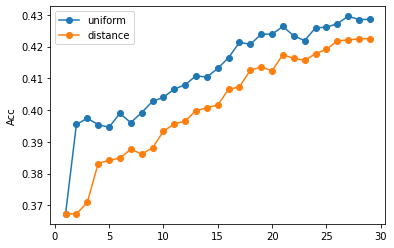

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

cv = KFold(n_splits = 5, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['playResult'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')   
    

plt.legend()
plt.show() 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_ss, static_defenses["playResult"], test_size=0.2)

In [ ]:
# constructor
n_neighbors = 27
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.40848990953375086


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.05154639 0.68041237 0.26804124]
 [0.02889246 0.62921348 0.34189406]
 [0.03632887 0.61950287 0.34416826]]


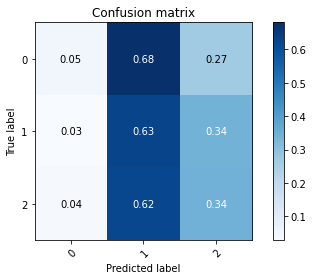

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')
  

##MinMaxScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,playResult
0,1.092351,-2.375257,-0.363644,1.565847,-2.361185,0.114325,1.000957,-0.344249,-1.714242,0.201704,4.573179,-2.122716,-1.231967,-0.580794,2
1,0.309173,-1.805309,-1.414376,-0.389621,0.557016,-0.508524,1.048196,-1.407330,-0.550243,-0.415755,-0.354923,0.293803,-0.549693,-0.271974,0
2,-1.776468,-2.614379,3.378850,1.423912,-0.757615,0.266991,-0.259697,-0.521819,-0.206379,3.805073,-1.112120,-0.775403,-0.444546,-0.930114,0
3,1.442056,0.951447,-0.718435,-0.867523,-2.117654,1.744920,-0.149562,-0.666288,-1.203691,0.103261,0.248834,-0.238580,0.723099,0.058862,1
4,-0.099209,0.081162,2.434513,-0.008253,-0.818410,-2.482883,-0.450512,-0.020628,0.416711,-0.824272,-0.827915,0.377317,-0.100807,-0.188015,0


Max Value uniform : 0.4280093971279201 (28)
Max Value distance : 0.4225334485590941 (28)


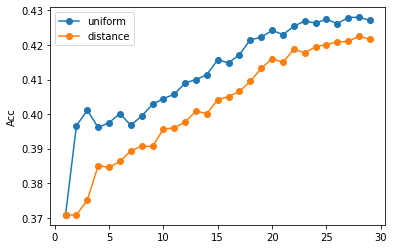

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['playResult'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')        
    

plt.legend()
plt.show() 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_mms, static_defenses["playResult"], test_size=0.2)

In [ ]:
# constructor
n_neighbors = 28
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.4194847020933977


Normalized confusion matrix
[[0.66958808 0.04119194 0.28921998]
 [0.63434343 0.04040404 0.32525253]
 [0.64740566 0.04834906 0.30424528]]


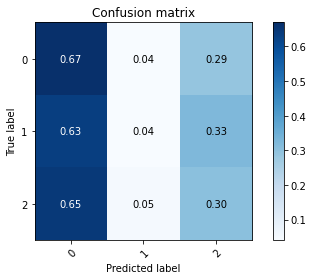

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')
  

##RobustScaler

In [ ]:
train_rs = pd.DataFrame(X_pca_rs)
train_rs["playResult"] = static_defenses["playResult"].values
train_rs.head()

,0,1,2,3,4,playResult
0,-3.094566,1.231072,-0.416059,-1.491454,-0.343607,2
1,-2.792118,1.323250,-0.871499,-1.202973,-0.798171,0
2,-3.514882,-0.398284,-1.036714,-1.728130,-1.207033,0
3,-2.996167,2.176192,0.401912,0.745607,-0.091481,1
4,-3.540146,0.960876,-0.283529,0.119248,-0.185623,0


Max Value uniform : 0.42953757045493896 (27)
Max Value distance : 0.42245102445421134 (29)


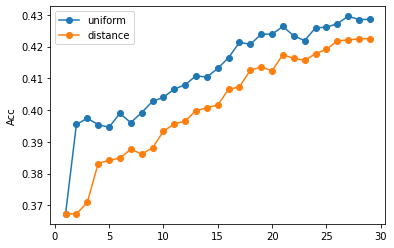

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 5, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_rs):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['playResult'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')   
    

plt.legend()
plt.show() 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_rs, static_defenses["playResult"], test_size=0.2)

In [ ]:
# constructor
n_neighbors = 27
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.43156199677938806


Normalized confusion matrix
[[0.72647318 0.02550572 0.24802111]
 [0.69247312 0.02365591 0.28387097]
 [0.70181406 0.03174603 0.26643991]]


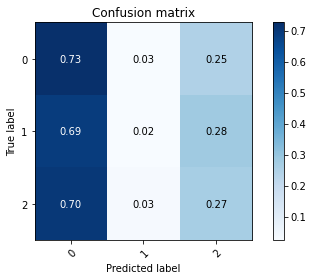

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')
  

##PowerTransformer

In [ ]:
train_pt = pd.DataFrame(X_pca_pt)
train_pt["playResult"] = static_defenses["playResult"].values
train_pt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,playResult
0,-0.918451,2.545004,-0.571638,-1.860245,-2.118816,0.370705,-1.959118,-1.608344,2.475429,3.653217,2.018998,-0.782918,0.895508,2
1,-0.252021,1.804681,-1.480887,0.126795,0.984615,-0.036604,-2.336800,-0.233366,0.290668,-0.583880,-0.618161,-0.054135,0.565390,0
2,2.466449,2.570463,3.385983,-1.886781,-0.593943,0.622752,-1.007688,0.117520,-3.277763,1.981460,-1.223908,-0.461270,-0.356456,0
3,-1.977075,-1.253661,-0.651970,1.001986,-2.139490,1.653708,-0.614016,-0.921469,-0.344567,0.141029,1.042574,0.177638,-0.769709,1
4,0.133085,-0.505937,2.366207,0.095400,-0.854854,-2.607872,-0.256706,0.125015,-0.225992,-1.299065,-0.084563,0.049070,-0.152829,0


Max Value uniform : 0.42953757045493896 (27)
Max Value distance : 0.42245102445421134 (29)


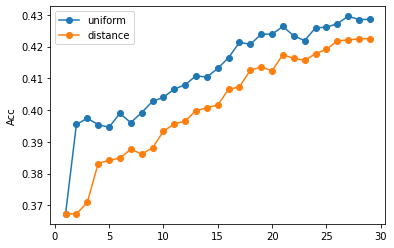

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 5, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_pt):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['playResult'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')    
    

plt.legend()
plt.show() 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_pt, static_defenses["playResult"], test_size=0.2)

In [ ]:
# constructor
n_neighbors = 20
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.4086151368760064


Normalized confusion matrix
[[0.65868794 0.04255319 0.29875887]
 [0.64937759 0.04356846 0.30705394]
 [0.66018307 0.05263158 0.28718535]]


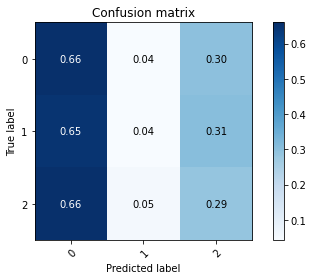

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')
  

#Decision Trees

##StandardScaler

In [ ]:
static_defenses

,numberWRs,width,HeightByWeightHook,densityInsidePointsNoLine,density,defenseAreaCoverDefenders,playResult
id,,,,,,,
2018090600:190:1,3,26.42,0.020120,6.969707,0.037004,165.05520,2
2018090600:492:1,2,19.61,0.019319,6.972530,0.048072,145.61535,2
2018090600:776:1,3,29.95,0.018251,7.975552,0.034065,163.61555,0
2018090600:839:1,3,29.30,0.020833,7.982448,0.041001,170.92430,0
2018090600:949:1,3,32.42,0.018484,6.969109,0.054060,129.48690,0
...,...,...,...,...,...,...,...
2018111802:1653:11,3,32.49,0.017609,6.976296,0.033185,210.93795,1
2018102109:4930:7,3,28.95,0.018071,7.989425,0.015734,472.82460,1
2018120908:2050:14,3,27.37,0.018021,8.967859,0.038670,186.67530,1


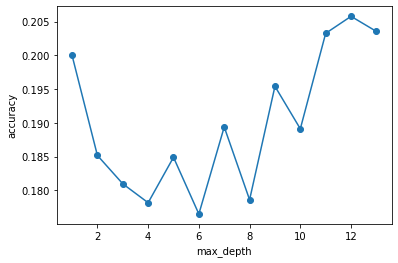

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(static_defenses))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:3.28}
                                            )
    for train_fold, test_fold in cv.split(static_defenses):
        f_train = static_defenses.iloc[train_fold]
        f_test = static_defenses.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['playResult'], axis=1), 
                               y = f_train['playResult'])
        test_acc = model.score(X = f_test.drop(['playResult'], axis=1), 
                                y = f_test['playResult'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(static_defenses.drop(["playResult"],axis=1),static_defenses["playResult"],test_size=0.2)

In [ ]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 10, 
                                  class_weight={0:3.28})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)


Acc 0.22883135059482154


In [ ]:
np.unique(y_pred)

array([0, 1, 2])

Normalized confusion matrix
[[0.81578947 0.12406015 0.06015038]
 [0.81309904 0.11341853 0.07348243]
 [0.81750466 0.10986965 0.0726257 ]]


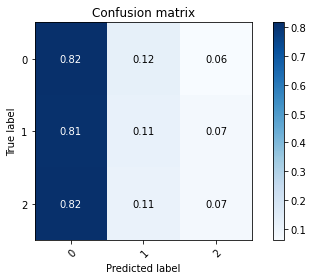

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

##MinMaxScaler

In [ ]:
train_mms = pd.DataFrame(X_pca_mms)
train_mms["playResult"] = static_defenses["playResult"].values
train_mms.head()

,0,1,2,3,4,5,6,7,playResult
0,-0.428010,0.139408,-0.329671,-0.147617,0.458216,-0.033739,-0.250385,-0.123836,2
1,-0.444604,-0.275629,0.904100,-0.355544,0.271800,-0.004144,0.174738,0.267716,2
2,0.784053,-0.089323,0.204728,0.375130,0.743245,0.251937,-0.095275,-0.036761,0
3,0.470285,0.571547,-0.229807,0.328557,0.309185,0.009286,-0.125013,0.014046,0
4,-0.374680,0.049434,-0.525219,-0.367326,-0.029586,-0.178615,0.015244,0.019528,0


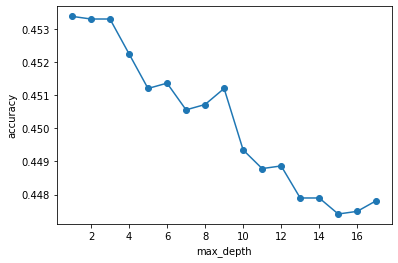

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(train_mms))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:3.28}
                                            )
    for train_fold, test_fold in cv.split(train_ss):
        f_train = train_ss.loc[train_fold]
        f_test = train_ss.loc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['playResult'], axis=1), 
                               y = f_train['playResult'])
        test_acc = model.score(X = f_test.drop(['playResult'], axis=1), 
                                y = f_test['playResult'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_mms.drop(["playResult"],axis=1),train_mms["playResult"],test_size=0.2)

In [ ]:
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 13, 
                                  class_weight={0:3.28})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)


Acc 0.2512178148921364


Normalized confusion matrix
[[0.74193548 0.21863799 0.03942652]
 [0.75433071 0.19055118 0.05511811]
 [0.76481836 0.17208413 0.06309751]]


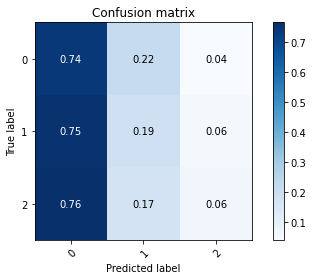

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

##RobustScaler

In [ ]:
train_rs = pd.DataFrame(X_pca_rs)
train_rs["playResult"] = static_defenses["playResult"].values
train_rs.head()

,0,1,2,3,4,playResult
0,-2.275574,2.233391,-1.001333,-0.977821,-2.064975,2
1,9.640493,0.026928,-1.403801,-1.804948,0.152415,2
2,-3.108033,0.590417,-0.420066,1.676489,-1.239991,0
3,-2.957280,2.071981,-1.604668,1.218633,-0.324105,0
4,-2.295734,2.892604,1.299272,-1.745112,-1.990499,0


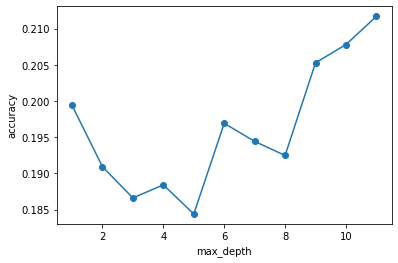

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(train_rs))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:3.28}
                                            )
    for train_fold, test_fold in cv.split(train_ss):
        f_train = train_ss.loc[train_fold]
        f_test = train_ss.loc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['playResult'], axis=1), 
                               y = f_train['playResult'])
        test_acc = model.score(X = f_test.drop(['playResult'], axis=1), 
                                y = f_test['playResult'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_rs.drop(["playResult"],axis=1),train_rs["playResult"],test_size=0.2)

In [ ]:
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 12, 
                                  class_weight={0:3.28})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)


Acc 0.27487821851078637


Normalized confusion matrix
[[0.70833333 0.26736111 0.02430556]
 [0.68881686 0.27228525 0.03889789]
 [0.70300752 0.2537594  0.04323308]]


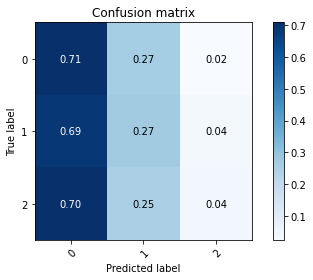

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

##PowerTransformer

In [ ]:
train_pt = pd.DataFrame(X_pca_pt)
train_pt["playResult"] = static_defenses["playResult"].values
train_pt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,playResult
0,-1.798221,1.472562,2.462210,-2.162657,0.058043,-1.436514,-1.351223,1.911595,-1.037560,-1.410456,0.427142,-0.110515,-0.337453,2
1,-3.155535,1.857961,1.501039,2.688067,2.446607,1.770079,0.615037,1.269569,0.363605,-0.932535,0.565066,-0.076233,-0.479128,2
2,0.833067,-1.588843,4.127295,-1.389067,-0.313453,0.687459,-2.771228,1.250819,0.310226,1.109032,0.911492,-0.030633,-0.798099,0
3,-0.348820,-1.762098,1.451567,-2.202566,-0.416513,0.161404,-0.810107,1.355933,-0.850878,-0.553029,-0.715365,-0.622233,0.691560,0
4,-2.485854,2.259136,-2.178487,-2.358970,0.717429,-0.514205,-0.162794,0.940852,0.405909,0.149640,1.503677,0.248870,-1.345541,0


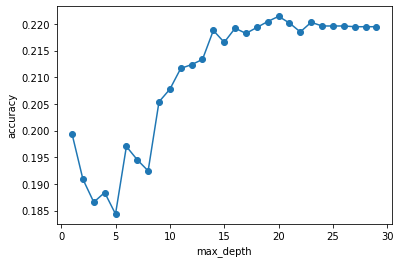

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(train_ss))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:3.28}
                                            )
    for train_fold, test_fold in cv.split(train_pt):
        f_train = train_ss.loc[train_fold]
        f_test = train_ss.loc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['playResult'], axis=1), 
                               y = f_train['playResult'])
        test_acc = model.score(X = f_test.drop(['playResult'], axis=1), 
                                y = f_test['playResult'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pt.drop(["playResult"],axis=1),train_pt["playResult"],test_size=0.3)

In [ ]:
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 15, 
                                  class_weight={0:3.28})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)


Acc 0.27690166975881264


Normalized confusion matrix
[[0.59657702 0.28117359 0.12224939]
 [0.63278008 0.27593361 0.09128631]
 [0.61174968 0.27713921 0.11111111]]


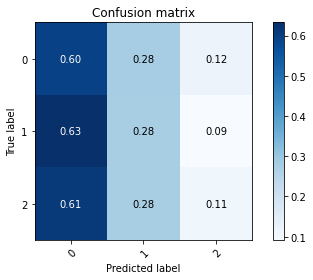

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

#RandomForest

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#1.1 Model Parametrization 
regressor = RandomForestClassifier(n_estimators= 100, max_depth = 10, random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.4244954766875435


Normalized confusion matrix
[[0.         0.82130584 0.17869416]
 [0.00160514 0.78009631 0.21829856]
 [0.00191205 0.76099426 0.23709369]]


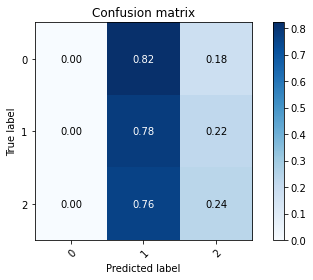

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

##MinMaxScaler

##RobustScaler

##PowerTransformer

#Boosting

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor  
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, criterion='mae'),n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("Error Measure", mean_absolute_error(y_test,y_pred))

Error Measure 4.69609345078514


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



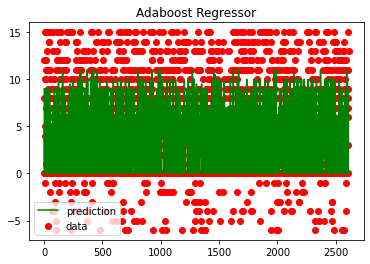

In [ ]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Adaboost Regressor")

plt.show()

##MinMaxScaler

##RobustScaler

##PowerTransformer